# Initialize the notebook and download some molecules

In [13]:
from preamble import *

2025-01-31 15:34:36,805 - WARNING - File .dacerc not found. You are requesting data in public mode. To change this behaviour, create a .dacerc file in your home directory and fill it with your API key. More infos on https://dace.unige.ch


  0%|          | 0/2 [00:00<?, ?it/s]

# Examine the bin edges 

  0%|          | 0/162 [00:00<?, ?it/s]

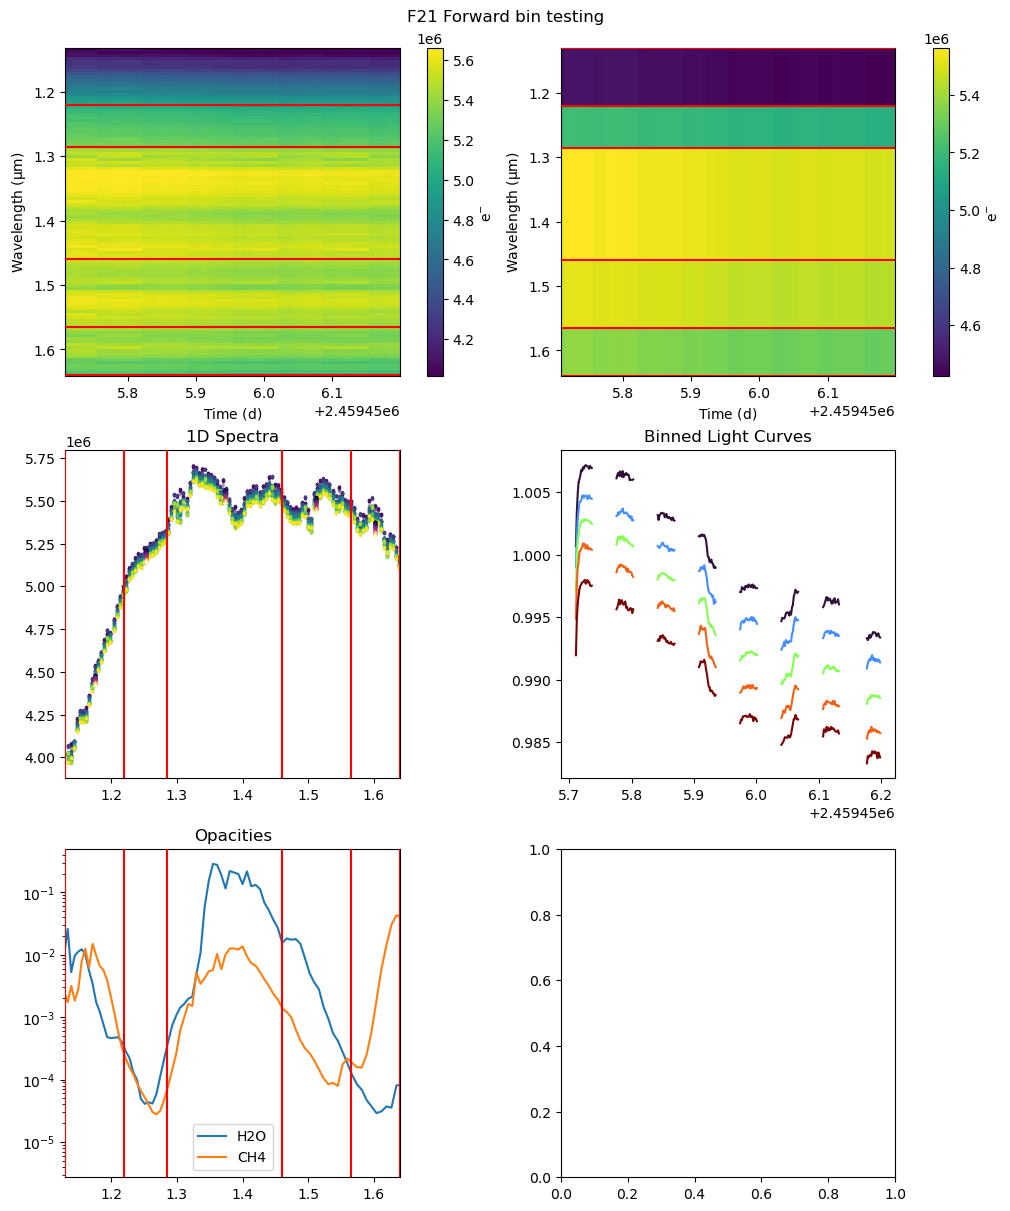

  0%|          | 0/162 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

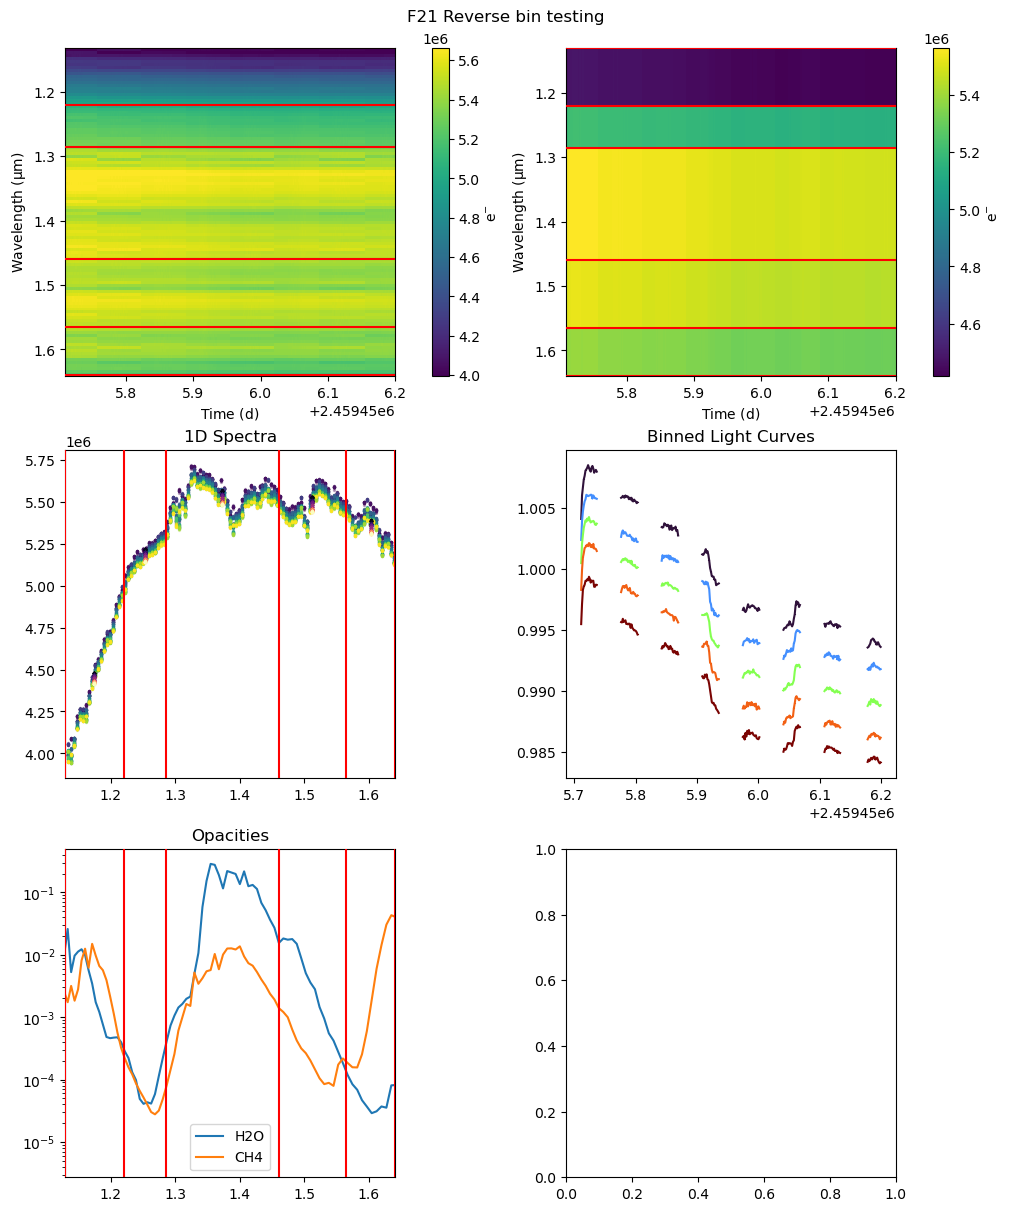

  0%|          | 0/160 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

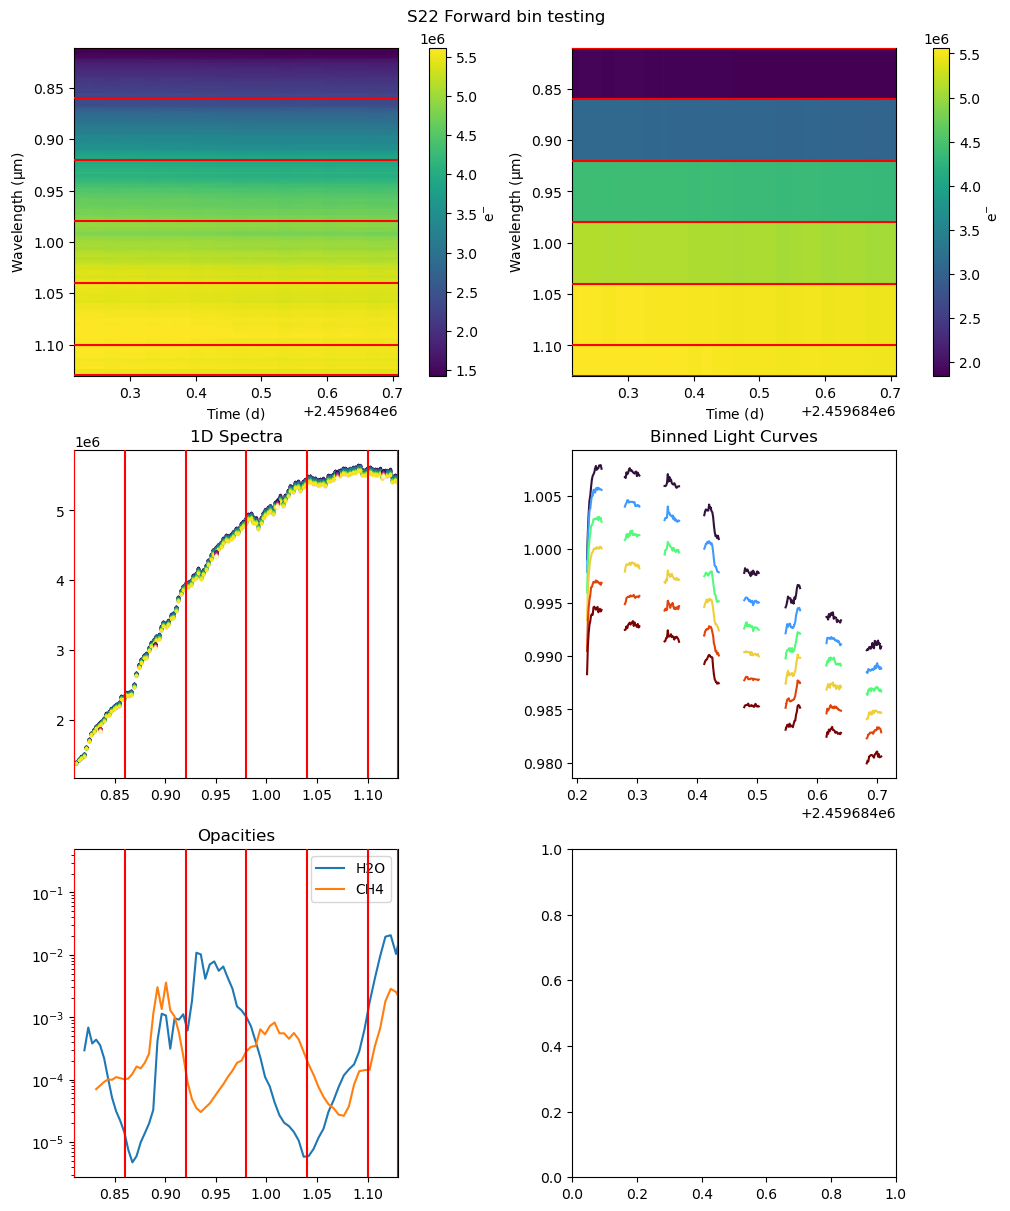

  0%|          | 0/160 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

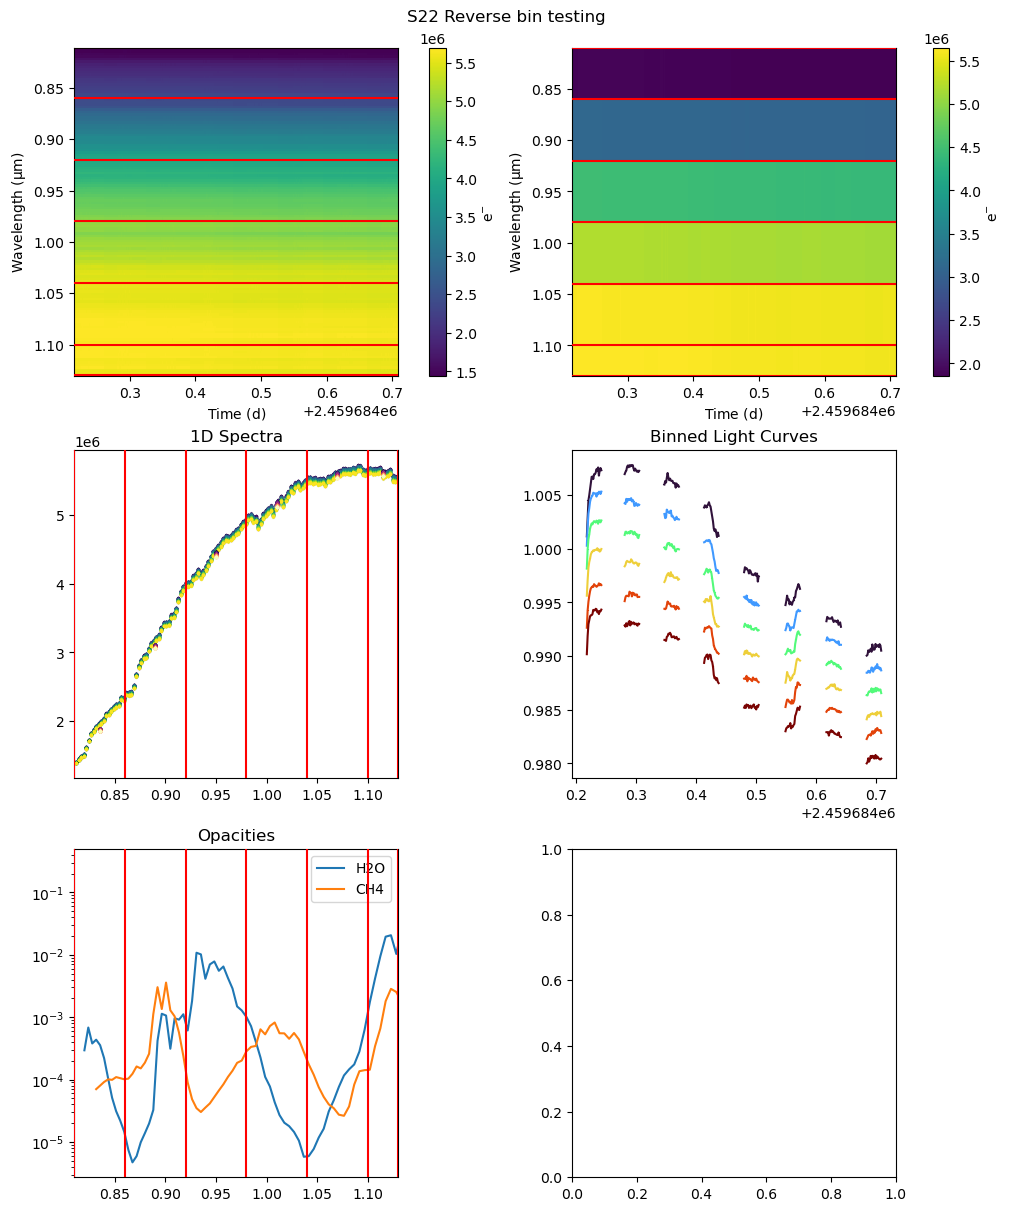

<Figure size 640x480 with 0 Axes>

In [27]:
F21_bin_edges = np.array([1.13, 1.22, 1.285, 1.46, 1.565, 1.64])
S22_bin_edges = np.array([0.81, 0.86, 0.92, 0.98, 1.04, 1.10, 1.13])

pressures = np.geomspace(1e-6, 100, 500)
temperatures = 600 * (pressures / 0.1) ** 0.08
species = ['H2O', 'CH4']
binned_opacities = []
        
for visit in ['F21','S22']:

    'Extract exposure times and mid-transit times from the dictionary'
    predicted_T0 = visits[f'{visit}']['T0 (BJD_TDB)'].value
    expTime = visits[f'{visit}']['exp (s)'].value
    if visit == 'F21':
        bin_edges = F21_bin_edges
    if visit == 'S22':
        bin_edges = S22_bin_edges
            
    for direction in ['Forward','Reverse']:
        'Read in the trimmed rainbows from process_pacman_spectra.ipynb'
        F_rainbow = read_rainbow(f"../data/{visit}_{direction}_trimmed_pacman_spec.rainbow.npy")
        binned = F_rainbow.bin(wavelength_edges = bin_edges*u.micron)
        img_date = binned.time.value
        time_in_seconds = img_date * 24 * 60 * 60
        orbit = np.zeros_like(img_date)

        for spec in species:
            op = Opacity.load_species_from_name(spec)
            binned_opacities.append(
                op.get_binned_interpolator(np.geomspace(0.82, 1.65, 150), temperatures, pressures) )
        mmw_neptune = 2.5  # [AMU]
        chem = FastchemWrapper(np.array([600]), np.array([0.01]))
        vmr = chem.vmr()
        weights = chem.get_weights()

        fig, axes = plt.subplots(3,2,figsize=(10, 12))
        axs = [axes[0,0], axes[0,1], axes[1,0], axes[1,1], axes[2,0],axes[2,1]]
        plt.suptitle(f'{visit} {direction} bin testing')
        # axs[0].set_title(f'{visit} {direction} WFC3 Spectrum')
        # axs[1].set_title('Binned Spectrum')
        axs[2].set_title('1D Spectra')
        axs[4].set_title('Opacities')
        axs[3].set_title('Binned Light Curves')
        
        F_rainbow.imshow(ax=axs[0])
        binned.imshow(ax=axs[1])
        
        for j in range(len(img_date)):
            if j >= 1:
                if (time_in_seconds[j] - time_in_seconds[j - 1]) > 1e3:
                    orbit[j] = (orbit[j - 1] + 1)
                else:
                    orbit[j] = orbit[j - 1]
    
        # if visit == 'S22':
        #     F_rainbow.flux.value[:, orbit == 2] = np.nan  # Set all data in the 2nd orbit to np.nan
        #     binned.flux.value[:, orbit == 2] = np.nan  # Set all data in the 2nd orbit to np.nan
        
        for o in np.unique(orbit[orbit >= 0]):  # Skip the 0th orbit
            first_index = np.where(orbit == o)[0][0]
            F_rainbow.flux.value[:, first_index] = np.nan  # Set the first point of each subsequent orbit to np.nan
            binned.flux.value[:, first_index] = np.nan  # Set the first point of each subsequent orbit to np.nan
        
        for edge in bin_edges:
            axs[0].axhline(edge,color='r',zorder=100)
            axs[1].axhline(edge,color='r',zorder=100)
            axs[2].axvline(edge,color='r',zorder=100)
            axs[4].axvline(edge,color='r',zorder=100)
        for i in range(len(F_rainbow.time.value)):
            axs[2].scatter(binned.wavelength, binned.flux[:,i],zorder=100,s=2,
                           color=plt.cm.magma((binned.time.value[i] - binned.time.value.min()) / np.ptp(binned.time.value)))
            axs[2].scatter(F_rainbow.wavelength, F_rainbow.flux[:,i],alpha=0.3,s=2,
                           color=plt.cm.viridis((F_rainbow.time.value[i] - F_rainbow.time.value.min()) / np.ptp(F_rainbow.time.value)))
        for i in range(len(binned.wavelength.value)):
            flux_i = binned.flux[i,:]
            flux_i/=np.nanmean(flux_i)
            axs[3].errorbar(binned.time, flux_i - (0.0025 * i), yerr=10e-6,
                            color=plt.cm.turbo((binned.wavelength.value[i] - binned.wavelength.value.min()) / np.ptp(binned.wavelength.value)))
        for i, spec in enumerate(species):
            op = binned_opacities[i](600, 0.01)[0]  # cm2 / g
            col_idx = chem.get_column_index(species_name=spec)[0]
            species_weight = weights[col_idx] / mmw_neptune
            abund_weighted_opacity = op * species_weight * vmr[:, col_idx]
            axs[4].semilogy(np.geomspace(0.82, 1.65, 150), abund_weighted_opacity, label=spec)
        axs[2].set_xlim(bin_edges[0],bin_edges[-1])
        axs[4].set_xlim(bin_edges[0],bin_edges[-1])
        axs[4].legend()
        plt.savefig(f'../figs/{visit}_{direction}_binned_lcs_testing.png')
        plt.show()
        plt.clf()